## **Europa's Magnetosphere with PINN**

We use the csv file with data from Galileo spacecraft flyby of Europa to train a Physics Informed Neural Network (PINN) to model the magnetic field around Europa. The data is preprocessed and split into training and testing sets. A neural network is defined with several hidden layers and trained using the Adam optimizer. The loss function combines the mean squared error of the predictions with the physical constraints of Maxwell's equations. After training, the model's performance is evaluated on the test set, and the results are visualized through plots comparing predicted and actual magnetic field values.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load and preprocess data
df1 = pd.read_csv("data/ORB04_EUR_EPHIO.csv")
df1 = df1.dropna()
X1 = df1[['SPACECRAFT EVENT TIME','BX','BY','BZ','B-FIELD MAGNITUDE','X','Y','Z']].values

df2 = pd.read_csv("data/ORB04_EUR_ESPRH.csv")
df2 = df2.dropna()
X2 = df2[['SPACECRAFT EVENT TIME','BR','BTHETA','BPHI','B-FIELD MAGNITUDE','RANGE','LATITUDE','LONGITUDE']].values

X = X2.copy()
X = X[:,(1, 2, 3, 5, 6, 7)]

X3 = np.concatenate((X1, X), axis=1)

X = X3
x = np.linspace(0, 8775, 8775)

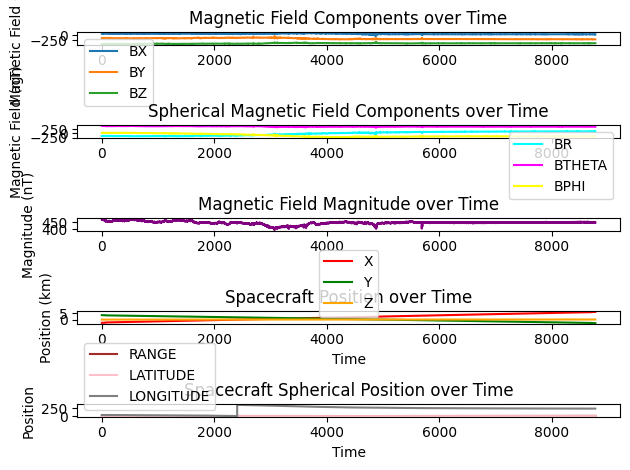

In [ ]:
ax1 = plt.subplot(5, 1, 1)
ax1.plot(x, X[:,1], label='BX')
ax1.plot(x, X[:,2], label='BY')
ax1.plot(x, X[:,3], label='BZ')
ax1.set_title('Magnetic Field Components over Time')
ax1.set_ylabel('Magnetic Field (nT)')
ax1.legend()
ax4 = plt.subplot(5, 1, 2)
ax4.plot(x, X[:,8], label='BR', color='cyan')
ax4.plot(x, X[:,9], label='BTHETA', color='magenta')
ax4.plot(x, X[:,10], label='BPHI', color='yellow')
ax4.set_title('Spherical Magnetic Field Components over Time')
ax4.set_ylabel('Magnetic Field (nT)')
ax4.legend()
ax2 = plt.subplot(5, 1, 3)
ax2.plot(x, X[:,4], color='purple')
ax2.set_title('Magnetic Field Magnitude over Time')
ax2.set_ylabel('Magnitude (nT)')
ax3 = plt.subplot(5, 1, 4)
ax3.plot(x, X[:,5], label='X', color='red')
ax3.plot(x, X[:,6], label='Y', color='green')
ax3.plot(x, X[:,7], label='Z', color='orange')
ax3.set_title('Spacecraft Position over Time')
ax3.set_xlabel('Time')
ax3.set_ylabel('Position (km)')
ax3.legend()
ax5 = plt.subplot(5, 1, 5)
ax5.plot(x, X[:,11], label='RANGE', color='brown')
ax5.plot(x, X[:,12], label='LATITUDE', color='pink')
ax5.plot(x, X[:,13], label='LONGITUDE', color='gray')
ax5.set_title('Spacecraft Spherical Position over Time')
ax5.set_xlabel('Time')
ax5.set_ylabel('Position')
ax5.legend()




plt.tight_layout()
plt.show()



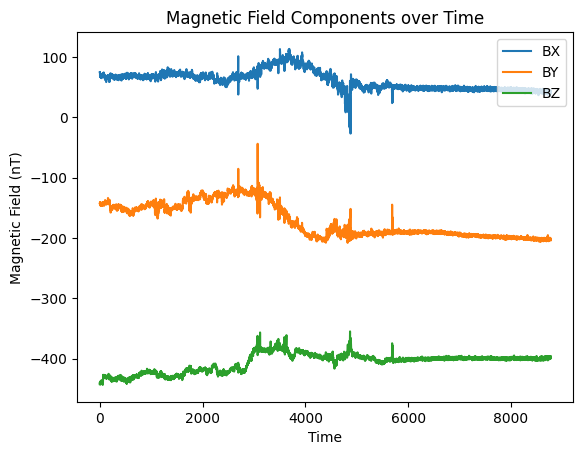

In [18]:
plt.plot(x, X[:,1], label='BX')
plt.plot(x, X[:,2], label='BY')
plt.plot(x, X[:,3], label='BZ')
plt.title('Magnetic Field Components over Time')
plt.xlabel('Time')
plt.ylabel('Magnetic Field (nT)')
plt.legend()
plt.show()

We use the data about magnetic field from the file `ORB04_EUR_EPHIO.csv` to train and evaluate our PINN model.
First, we need to interp

### Using ESPRH (Europa-centric spherical) coordinates
The EPHIO file uses Jupiter-centered coordinates, so for a local Europa view the ESPRH spherical set is preferable. Below we convert ESPRH `RANGE`/`LATITUDE`/`LONGITUDE` (Europa radii, deg) plus spherical field components (`BR`, `BTHETA`, `BPHI`) into Cartesian positions and vectors for a 3D quiver. Assumptions: `BR` is radial outward, `BTHETA` is along decreasing colatitude (polar), `BPHI` is azimuthal (east-longitude), and `LATITUDE` is planetographic latitude (so colatitude = 90°−latitude). Adjust if your sign conventions differ.

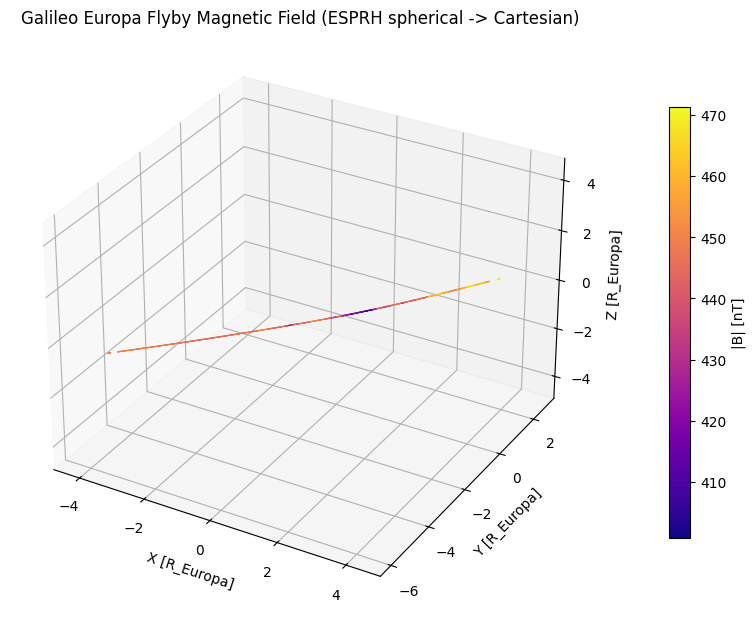

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import plasma

# Load spherical frame data (Europa-centric)
df_sph = pd.read_csv("data/ORB04_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])

# Down-sample for legibility
stride = max(len(df_sph) // 2000, 1)
d = df_sph.iloc[::stride].copy()

# Convert degrees to radians and spherical -> Cartesian
theta = np.deg2rad(90.0 - d["LATITUDE"].to_numpy())  # colatitude
phi = np.deg2rad(d["LONGITUDE"].to_numpy())         # longitude
r = d["RANGE"].to_numpy()                             # Europa radii

# Positions in Cartesian (Europa radii)
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

# Spherical components -> Cartesian (assumes standard physics convention)
Br = d["BR"].to_numpy()
Btheta = d["BTHETA"].to_numpy()
Bphi = d["BPHI"].to_numpy()

Bx = Br * np.sin(theta) * np.cos(phi) + Btheta * np.cos(theta) * np.cos(phi) - Bphi * np.sin(phi)
By = Br * np.sin(theta) * np.sin(phi) + Btheta * np.cos(theta) * np.sin(phi) + Bphi * np.cos(phi)
Bz = Br * np.cos(theta) - Btheta * np.sin(theta)

# Magnitude for coloring
Bmag = np.sqrt(Bx**2 + By**2 + Bz**2)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

norm = Normalize(vmin=Bmag.min(), vmax=Bmag.max())
colors = plasma(norm(Bmag))

ax.quiver(
    x, y, z,
    Bx, By, Bz,
    length=0.05, normalize=True, colors=colors, linewidth=0.4
)

mappable = plt.cm.ScalarMappable(norm=norm, cmap=plasma)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, shrink=0.7)
cbar.set_label("|B| [nT]")

ax.set_xlabel("X [R_Europa]")
ax.set_ylabel("Y [R_Europa]")
ax.set_zlabel("Z [R_Europa]")
ax.set_title("Galileo Europa Flyby Magnetic Field (ESPRH spherical -> Cartesian)")

# Equal-ish aspect
lims = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
center = lims.mean(axis=1)
radius = (lims[:,1] - lims[:,0]).max() / 2
ax.set_xlim3d([center[0]-radius, center[0]+radius])
ax.set_ylim3d([center[1]-radius, center[1]+radius])
ax.set_zlim3d([center[2]-radius, center[2]+radius])

plt.show()

### 3D normalized vector field with Europa sphere
Normalized arrows show direction; colors encode |B|. Europa shown as a unit-radius sphere for flyby context.

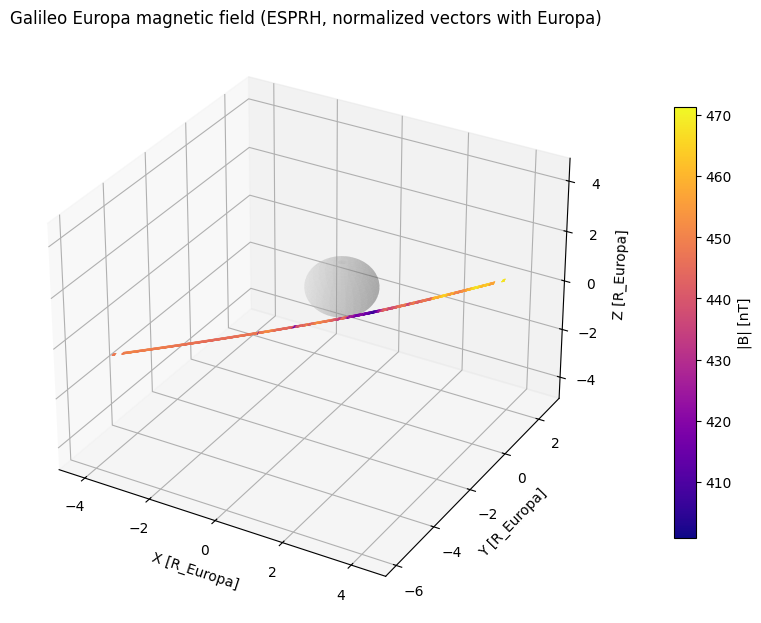

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import plasma

# Load ESPRH spherical data
df_sph = pd.read_csv("data/ORB04_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])

# Down-sample for legibility
stride = max(len(df_sph) // 2000, 1)
d = df_sph.iloc[::stride].copy()

# Spherical -> Cartesian positions
theta = np.deg2rad(90.0 - d["LATITUDE"].to_numpy())
phi = np.deg2rad(d["LONGITUDE"].to_numpy())
r = d["RANGE"].to_numpy()

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

# Spherical components -> Cartesian vectors
Br = d["BR"].to_numpy()
Btheta = d["BTHETA"].to_numpy()
Bphi = d["BPHI"].to_numpy()

Bx = Br * np.sin(theta) * np.cos(phi) + Btheta * np.cos(theta) * np.cos(phi) - Bphi * np.sin(phi)
By = Br * np.sin(theta) * np.sin(phi) + Btheta * np.cos(theta) * np.sin(phi) + Bphi * np.cos(phi)
Bz = Br * np.cos(theta) - Btheta * np.sin(theta)

# Magnitude and unit vectors
Bmag = np.sqrt(Bx**2 + By**2 + Bz**2)
Bx_u = Bx / Bmag
By_u = By / Bmag
Bz_u = Bz / Bmag

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

# Europa sphere (radius = 1 R_Europa)
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(xs, ys, zs, color="lightgray", alpha=0.25, linewidth=0, zorder=0)

norm = Normalize(vmin=Bmag.min(), vmax=Bmag.max())
colors = plasma(norm(Bmag))

ax.quiver(
    x, y, z,
    Bx_u, By_u, Bz_u,
    length=0.12, normalize=False, colors=colors, linewidth=0.4
)

mappable = plt.cm.ScalarMappable(norm=norm, cmap=plasma)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, shrink=0.7)
cbar.set_label("|B| [nT]")

ax.set_xlabel("X [R_Europa]")
ax.set_ylabel("Y [R_Europa]")
ax.set_zlabel("Z [R_Europa]")
ax.set_title("Galileo Europa magnetic field (ESPRH, normalized vectors with Europa)")

# Equal-ish aspect
lims = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
center = lims.mean(axis=1)
radius = (lims[:,1] - lims[:,0]).max() / 2
ax.set_xlim3d([center[0]-radius, center[0]+radius])
ax.set_ylim3d([center[1]-radius, center[1]+radius])
ax.set_zlim3d([center[2]-radius, center[2]+radius])

plt.show()

now let's try to plot the trajectories of additional 2 flybys and visualize all 3 flybys together with Europa sphere in the center. 

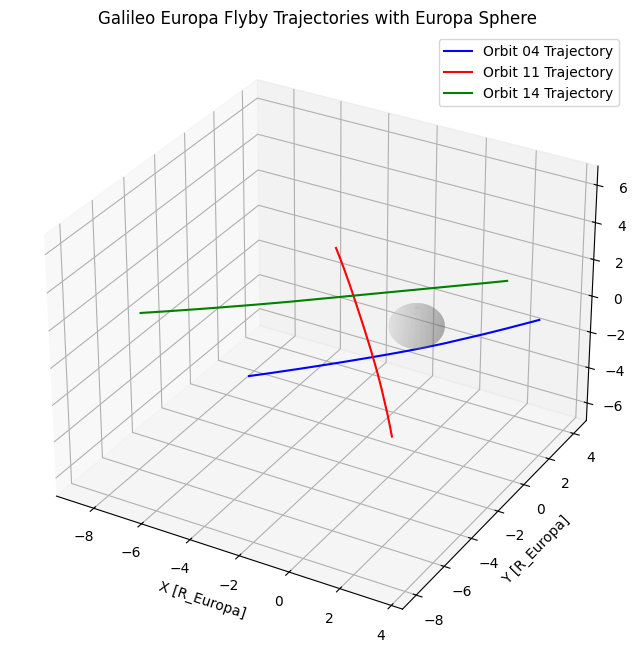

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# now let's try to plot the trajectories of additional 2 flybys and visualize all 3 flybys together with Europa sphere in the center. 

df = pd.read_csv("data/ORB04_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])
df2 = pd.read_csv("data/ORB11_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])
df3 = pd.read_csv("data/ORB14_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])


stride = max(len(df) // 2000, 1)
d = df.iloc[::stride].copy()
stride2 = max(len(df2) // 2000, 1)
d2 = df2.iloc[::stride2].copy()
stride3 = max(len(df3) // 2000, 1)
d3 = df3.iloc[::stride3].copy()

# Spherical -> Cartesian positions for flyby 1
theta = np.deg2rad(90.0 - d["LATITUDE"].to_numpy())
phi = np.deg2rad(d["LONGITUDE"].to_numpy())
r = d["RANGE"].to_numpy()
x1 = r * np.sin(theta) * np.cos(phi)
y1 = r * np.sin(theta) * np.sin(phi)
z1 = r * np.cos(theta)

# Spherical -> Cartesian positions for flyby 2
theta2 = np.deg2rad(90.0 - d2["LATITUDE"].to_numpy())
phi2 = np.deg2rad(d2["LONGITUDE"].to_numpy())
r2 = d2["RANGE"].to_numpy()
x2 = r2 * np.sin(theta2) * np.cos(phi2)
y2 = r2 * np.sin(theta2) * np.sin(phi2)
z2 = r2 * np.cos(theta2)

# Spherical -> Cartesian positions for flyby 3
theta3 = np.deg2rad(90.0 - d3["LATITUDE"].to_numpy())
phi3 = np.deg2rad(d3["LONGITUDE"].to_numpy())
r3 = d3["RANGE"].to_numpy()
x3 = r3 * np.sin(theta3) * np.cos(phi3)
y3 = r3 * np.sin(theta3) * np.sin(phi3)
z3 = r3 * np.cos(theta3)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

# Europa sphere (radius = 1 R_Europa)
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(xs, ys, zs, color="lightgray", alpha=0.25, linewidth=0, zorder=0)

ax.plot3D(x1, y1, z1, color='blue', label='Orbit 04 Trajectory')
ax.plot3D(x2, y2, z2, color='red', label='Orbit 11 Trajectory')
ax.plot3D(x3, y3, z3, color='green', label='Orbit 14 Trajectory')
ax.set_xlabel("X [R_Europa]")
ax.set_ylabel("Y [R_Europa]")
ax.set_zlabel("Z [R_Europa]")
ax.set_title("Galileo Europa Flyby Trajectories with Europa Sphere")
ax.legend()

# Equal-ish aspect
lims = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
center = lims.mean(axis=1)
radius = (lims[:,1] - lims[:,0]).max() / 2
ax.set_xlim3d([center[0]-radius, center[0]+radius])
ax.set_ylim3d([center[1]-radius, center[1]+radius])
ax.set_zlim3d([center[2]-radius, center[2]+radius])
plt.show()

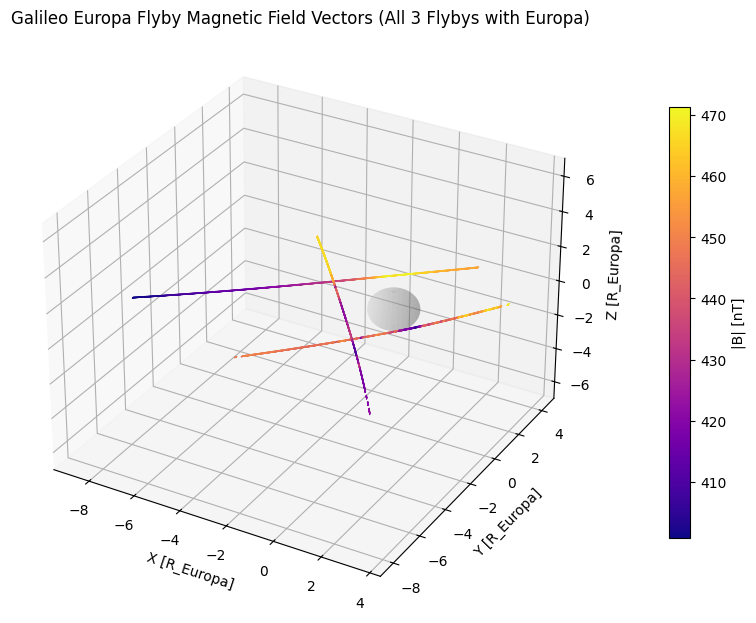

In [5]:
# now let's do another plot but as in the previous one, with magnetic field vectors along the trajectories of all 3 flybys.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import plasma

# Load ESPRH spherical data for all 3 flybys
df1 = pd.read_csv("data/ORB04_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])
df2 = pd.read_csv("data/ORB11_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])
df3 = pd.read_csv("data/ORB14_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])

# Down-sample for legibility
stride1 = max(len(df1) // 2000, 1)
d1 = df1.iloc[::stride1].copy()
stride2 = max(len(df2) // 2000, 1)
d2 = df2.iloc[::stride2].copy()
stride3 = max(len(df3) // 2000, 1)
d3 = df3.iloc[::stride3].copy()

# Spherical -> Cartesian positions for flyby 1
theta = np.deg2rad(90.0 - d["LATITUDE"].to_numpy())
phi = np.deg2rad(d["LONGITUDE"].to_numpy())
r = d["RANGE"].to_numpy()
x1 = r * np.sin(theta) * np.cos(phi)
y1 = r * np.sin(theta) * np.sin(phi)
z1 = r * np.cos(theta)

# Spherical -> Cartesian positions for flyby 2
theta2 = np.deg2rad(90.0 - d2["LATITUDE"].to_numpy())
phi2 = np.deg2rad(d2["LONGITUDE"].to_numpy())
r2 = d2["RANGE"].to_numpy()
x2 = r2 * np.sin(theta2) * np.cos(phi2)
y2 = r2 * np.sin(theta2) * np.sin(phi2)
z2 = r2 * np.cos(theta2)

# Spherical -> Cartesian positions for flyby 3
theta3 = np.deg2rad(90.0 - d3["LATITUDE"].to_numpy())
phi3 = np.deg2rad(d3["LONGITUDE"].to_numpy())
r3 = d3["RANGE"].to_numpy()
x3 = r3 * np.sin(theta3) * np.cos(phi3)
y3 = r3 * np.sin(theta3) * np.sin(phi3)
z3 = r3 * np.cos(theta3)

# Spherical components -> Cartesian vectors for flyby 1
Br1 = d1["BR"].to_numpy()
Btheta1 = d1["BTHETA"].to_numpy()
Bphi1 = d1["BPHI"].to_numpy()
Bx1 = Br1 * np.sin(theta) * np.cos(phi) + Btheta1 * np.cos(theta) * np.cos(phi) - Bphi1 * np.sin(phi)
By1 = Br1 * np.sin(theta) * np.sin(phi) + Btheta1 * np.cos(theta) * np.sin(phi) + Bphi1 * np.cos(phi)
Bz1 = Br1 * np.cos(theta) - Btheta1 * np.sin(theta)
Bmag1 = np.sqrt(Bx1**2 + By1**2 + Bz1**2)
Bx1_u = Bx1 / Bmag1
By1_u = By1 / Bmag1
Bz1_u = Bz1 / Bmag1

# Spherical components -> Cartesian vectors for flyby 2
Br2 = d2["BR"].to_numpy()
Btheta2 = d2["BTHETA"].to_numpy()
Bphi2 = d2["BPHI"].to_numpy()
Bx2 = Br2 * np.sin(theta2) * np.cos(phi2) + Btheta2 * np.cos(theta2) * np.cos(phi2) - Bphi2 * np.sin(phi2)
By2 = Br2 * np.sin(theta2) * np.sin(phi2) + Btheta2 * np.cos(theta2) * np.sin(phi2) + Bphi2 * np.cos(phi2)
Bz2 = Br2 * np.cos(theta2) - Btheta2 * np.sin(theta2)
Bmag2 = np.sqrt(Bx2**2 + By2**2 + Bz2**2)
Bx2_u = Bx2 / Bmag2
By2_u = By2 / Bmag2
Bz2_u = Bz2 / Bmag2

# Spherical components -> Cartesian vectors for flyby 3
Br3 = d3["BR"].to_numpy()
Btheta3 = d3["BTHETA"].to_numpy()
Bphi3 = d3["BPHI"].to_numpy()
Bx3 = Br3 * np.sin(theta3) * np.cos(phi3) + Btheta3 * np.cos(theta3) * np.cos(phi3) - Bphi3 * np.sin(phi3)
By3 = Br3 * np.sin(theta3) * np.sin(phi3) + Btheta3 * np.cos(theta3) * np.sin(phi3) + Bphi3 * np.cos(phi3)
Bz3 = Br3 * np.cos(theta3) - Btheta3 * np.sin(theta3)
Bmag3 = np.sqrt(Bx3**2 + By3**2 + Bz3**2)
Bx3_u = Bx3 / Bmag3
By3_u = By3 / Bmag3
Bz3_u = Bz3 / Bmag3

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

# Europa sphere (radius = 1 R_Europa)
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(xs, ys, zs, color="lightgray", alpha=0.25, linewidth=0, zorder=0)

norm1 = Normalize(vmin=Bmag1.min(), vmax=Bmag1.max())
colors1 = plasma(norm1(Bmag1))
ax.quiver(
    x1, y1, z1,
    Bx1_u, By1_u, Bz1_u,
    length=0.12, normalize=False, colors=colors1, linewidth=0.4
)
norm2 = Normalize(vmin=Bmag2.min(), vmax=Bmag2.max())
colors2 = plasma(norm2(Bmag2))
ax.quiver(
    x2, y2, z2,
    Bx2_u, By2_u, Bz2_u,
    length=0.12, normalize=False, colors=colors2, linewidth=0.4
)
norm3 = Normalize(vmin=Bmag3.min(), vmax=Bmag3.max())
colors3 = plasma(norm3(Bmag3))
ax.quiver(
    x3, y3, z3,
    Bx3_u, By3_u, Bz3_u,
    length=0.12, normalize=False, colors=colors3, linewidth=0.4
)
mappable = plt.cm.ScalarMappable(norm=norm1, cmap=plasma)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, shrink=0.7)
cbar.set_label("|B| [nT]")
ax.set_xlabel("X [R_Europa]")
ax.set_ylabel("Y [R_Europa]")
ax.set_zlabel("Z [R_Europa]")
ax.set_title("Galileo Europa Flyby Magnetic Field Vectors (All 3 Flybys with Europa)")

# Equal-ish aspect
lims = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
center = lims.mean(axis=1)
radius = (lims[:,1] - lims[:,0]).max() / 2
ax.set_xlim3d([center[0]-radius, center[0]+radius])
ax.set_ylim3d([center[1]-radius, center[1]+radius])
ax.set_zlim3d([center[2]-radius, center[2]+radius])
plt.show()